In [1]:
!pip install fcapy[all]
!pip install frozendict
!pip install ipynb
!pip install sparselinear
!pip install bitsets
!pip install bitarray
import torch
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.0.0+cuda118.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.0.0+cuda118.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-2.0.0+cuda118.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

  Using cached fcapy-0.1.4.3-py3-none-any.whl.metadata (50 kB)
  Using cached scikit_mine-1.0.0-py3-none-any.whl (118 kB)
  Using cached caspailleur-0.1.3-py3-none-any.whl.metadata (53 kB)
  Using cached ipywidgets-8.1.1-py3-none-any.whl.metadata (2.4 kB)
  Using cached pyroaring-0.4.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (10 kB)
  Using cached sortedcontainers-2.4.0-py2.py3-none-any.whl (29 kB)
  Using cached dataclasses-0.6-py3-none-any.whl (14 kB)
  Using cached wget-3.2-py3-none-any.whl
  Using cached pydot-1.4.2-py2.py3-none-any.whl (21 kB)
  Using cached widgetsnbextension-4.0.9-py3-none-any.whl.metadata (1.6 kB)
  Using cached jupyterlab_widgets-3.0.9-py3-none-any.whl.metadata (4.1 kB)
Using cached caspailleur-0.1.3-py3-none-any.whl (43 kB)
Using cached fcapy-0.1.4.3-py3-none-any.whl (162 kB)
Using cached ipywidgets-8.1.1-py3-none-any.whl (139 kB)
Using cached jupyterlab_widgets-3.0.9-py3-none-any.whl (214 kB)
Using cached pyroaring-0.4.4-cp310-cp3

In [2]:
import torch

# Import libs

In [3]:
import numpy as np
import pandas as pd

In [4]:
from fcapy.context import FormalContext
from fcapy.lattice import ConceptLattice

In [5]:
from fcapy.visualizer import LineVizNx
import matplotlib.pyplot as plt

plt.rcParams['figure.facecolor'] = (1,1,1,1)

In [6]:
import neural_lib as nl

In [7]:
df = pd.read_csv('https://raw.githubusercontent.com/EgorDudyrev/FCApy/main/data/mango_bin.csv', index_col=0)
df.columns = [f.split('_')[-1] for f in df.columns]
df.head()

,firm,smooth,fruit,yellow,green,blue,white,round,oval,cubic
title,,,,,,,,,,
apple,False,True,True,True,False,False,False,True,False,False
grapefruit,False,False,True,True,False,False,False,True,False,False
kiwi,False,False,True,False,True,False,False,False,True,False
plum,False,True,True,False,False,True,False,False,True,False
toy cube,True,True,False,False,True,False,False,False,False,True


# Pipeline

# Step 0. Binarize the data

In [8]:
df_bin = df  # Skip this part as the data is already binary

Split the data to train and test

In [9]:
y_feat = 'fruit'
df_test = df_bin.loc[['mango']]
df_train = df_bin.drop(df_test.index, axis=0)

In [10]:
X_train, y_train = df_train.drop(y_feat, axis=1), df_train[y_feat]
X_test, y_test = df_test.drop(y_feat, axis=1), df_test[y_feat]

## Step 1. Build Monotone Concept Lattice

Put binarized data in FormalContext and compute monotone ConceptLattice

In [11]:
K_train = FormalContext.from_pandas(X_train)
K_train

FormalContext (7 objects, 9 attributes, 20 connections)
           |firm|smooth|yellow|green|blue|white|round|oval|cubic|
apple      |    |     X|     X|     |    |     |    X|    |     |
grapefruit |    |      |     X|     |    |     |    X|    |     |
kiwi       |    |      |      |    X|    |     |     |   X|     |
plum       |    |     X|      |     |   X|     |     |   X|     |
toy cube   |   X|     X|      |    X|    |     |     |    |    X|
egg        |   X|     X|      |     |    |    X|     |   X|     |
tennis ball|    |      |      |     |    |    X|    X|    |     |

In [12]:
L = ConceptLattice.from_context(K_train, is_monotone=True)
len(L)

46

Compute F1 score for each formal concept  (assuming that an object is predicted True if it is in the extent of the concept)

In [13]:
from sklearn.metrics import f1_score

for c in L:
    y_preds = np.zeros(K_train.n_objects)
    y_preds[list(c.extent_i)] = 1
    # c.measures['f1_score'] = f1_score(y_train, y_preds)
    c.measures = c.measures.set('f1_score', f1_score(y_train, y_preds))

Select indices of the best concepts from the lattice

In [14]:
best_concepts = list(L.measures['f1_score'].argsort()[::-1][:7])

assert len({g_i for c in L[best_concepts] for g_i in c.extent_i})==K_train.n_objects, "Selected concepts do not cover all train objects"

Construct neural network based on concept lattice

In [15]:
cn = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y_train)))

Setup visuzalier for the architecture

In [16]:
vis = LineVizNx(node_label_font_size=14, node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes))+'\n\n')

Move the nodes in visualization to make it look pretty

In [17]:
vis.init_mover_per_poset(cn.poset)
mvr = vis.mover
for a, b in [(11, 15), (2, 3), (2,8), (2, 4), (4,5), (24, 26), (22, 26), (23, 25), (22, 24), (6, 7), ]:
    mvr.swap_nodes(a, b)

for nodes, vert in [
    ([19, 18], 0), ([23, 22], 5), ([14, 21,20], 1), ([13, 24, 25], 6), ([26], 7), ([9, 15], 8)
]:
    for a in nodes:
        mvr.place_node(a, mvr.posx[vert])

In [18]:
descr = {'smooth', 'green', 'oval'}

traced = cn.trace_description(descr, include_targets=False)

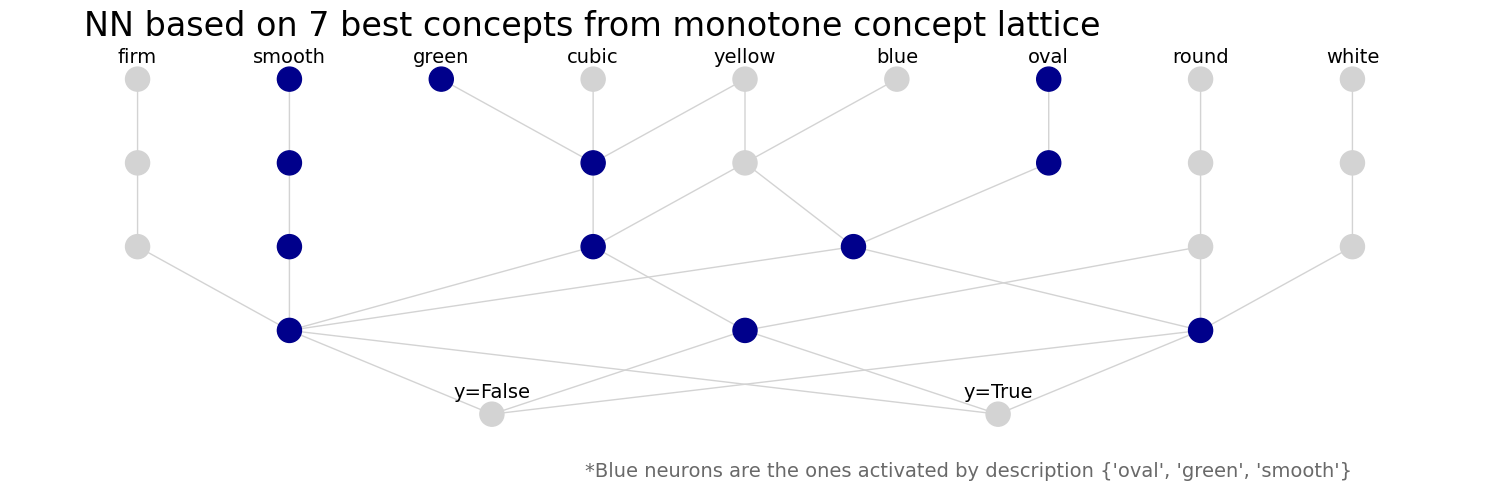

In [19]:
fig, ax = plt.subplots(figsize=(15,5))

vis.draw_poset(
    cn.poset, ax=ax,
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes), only_new_attrs=True)+'\n\n',
    node_color=['darkblue' if el_i in traced else 'lightgray' for el_i in range(len(cn.poset))]
)
plt.title(f'NN based on 7 best concepts from monotone concept lattice', loc='left', x=0.05, size=24)

plt.text(max(vis.mover.posx), min(vis.mover.posy)-0.3, f'*Blue neurons are the ones activated by description {descr}', fontsize=14, ha='right', color='dimgray')

plt.subplots_adjust()
plt.tight_layout()
plt.show()

Now fit the network

In [20]:
cn.fit(X_train, y_train)

To obtain the prediction

In [21]:
print('Class prediction', cn.predict(X_test).numpy())
print('Class prediction with probabilities', cn.predict_proba(X_test).detach().numpy())
print('True class', y_test.values)

Class prediction [1]
Class prediction with probabilities [[0.35615927 0.6438407 ]]
True class [ True]


Let us look at the fitted weights of edges

In [22]:
edge_weights = cn.edge_weights_from_network()

/home/aseliverstov/.cache/pypoetry/virtualenvs/osda-bhw-kYdWE48u-py3.10/lib/python3.10/site-packages/sparselinear/sparselinear.py:301: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:605.)
  weight = torch.sparse.FloatTensor(self.indices, self.weights, (self.out_features, self.in_features))


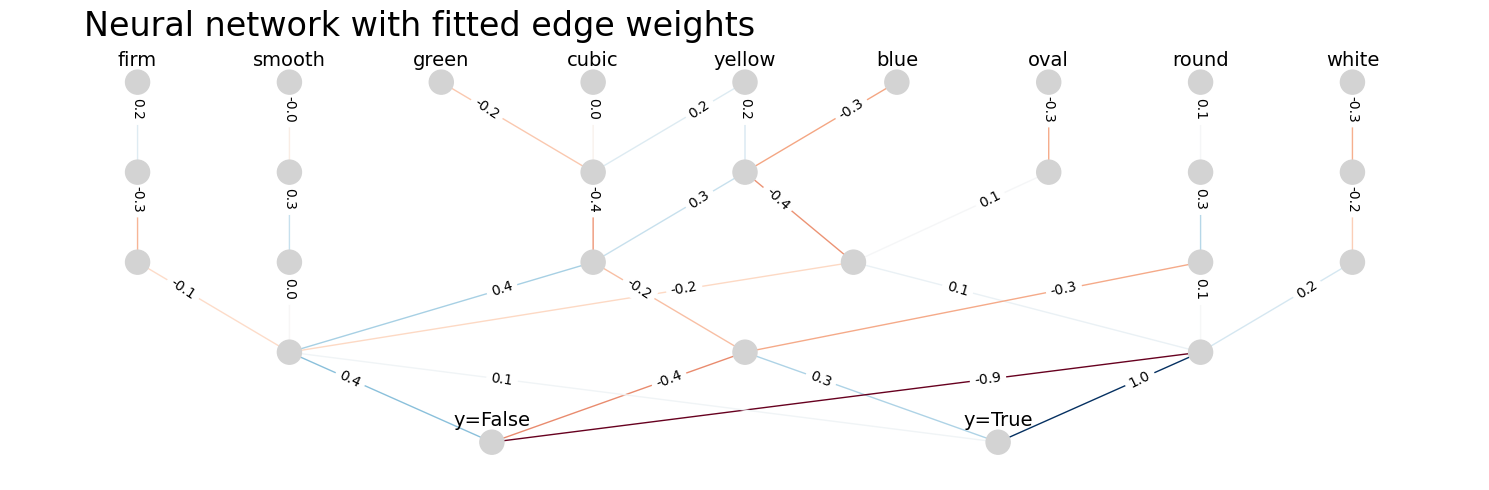

In [23]:
import networkx as nx

fig, ax = plt.subplots(figsize=(15,5))

vis.draw_poset(
    cn.poset, ax=ax,
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes), only_new_attrs=True)+'\n\n',
    edge_color=[edge_weights[edge] for edge in cn.poset.to_networkx().edges],
    edge_cmap=plt.cm.RdBu,
)
nx.draw_networkx_edge_labels(cn.poset.to_networkx(), vis.mover.pos, {k: f"{v:.1f}" for k,v in edge_weights.items()}, label_pos=0.7)

plt.title('Neural network with fitted edge weights', size=24, x=0.05, loc='left')
plt.tight_layout()
plt.subplots_adjust()
plt.savefig('fitted_network.png')
plt.show()